In [2]:
%load_ext tensorboard

In [1]:
import datetime, os

from pathlib import Path
from matplotlib import pyplot as plt
from quickdraw import QuickDrawDataGroup, QuickDrawData

from tensorflow.keras.preprocessing import image_dataset_from_directory

from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import sparse_categorical_accuracy
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization

from tensorflow.keras.callbacks import TensorBoard

2022-02-20 18:32:33.093726: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-20 18:32:33.093751: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [4]:
image_size = (28, 28)

In [ ]:
def generate_class_images(name, max_drawings, recognized):
    directory = Path("dataset/" + name)

    if not directory.exists():
        directory.mkdir(parents=True)

    images = QuickDrawDataGroup(name, max_drawings=max_drawings, recognized=recognized)
    for img in images.drawings:
        filename = directory.as_posix() + "/" + str(img.key_id) + ".png"
        img.get_image(stroke_width=3).resize(image_size).save(filename)

for label in QuickDrawData().drawing_names:
    generate_class_images(label, max_drawings=1200, recognized=True)

In [5]:
batch_size = 32

train_ds = image_dataset_from_directory(
    "dataset",
    validation_split=0.2,
    subset="training",
    seed=123,
    color_mode="grayscale",
    image_size=image_size,
    batch_size=batch_size
)

val_ds = image_dataset_from_directory(
    "dataset",
    validation_split=0.2,
    subset="validation",
    seed=123,
    color_mode="grayscale",
    image_size=image_size,
    batch_size=batch_size
)

Found 448500 files belonging to 345 classes.
Using 358800 files for training.


2022-02-20 18:33:47.967880: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-02-20 18:33:47.967911: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-20 18:33:47.967930: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (lars-UM700): /proc/driver/nvidia/version does not exist
2022-02-20 18:33:47.968221: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 448500 files belonging to 345 classes.
Using 89700 files for validation.


2022-02-20 18:34:09.082751: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


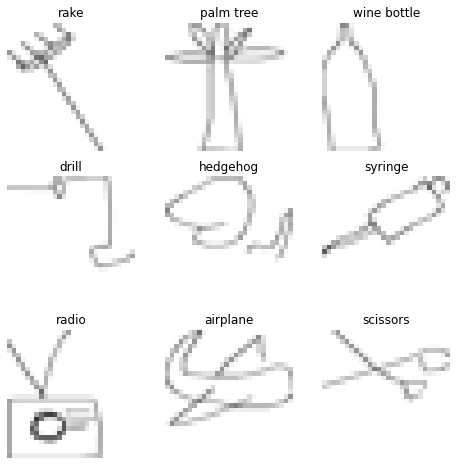

In [6]:
plt.figure(figsize=(8, 8))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        data = images[i].numpy().astype("uint8")
        plt.imshow(data, cmap='gray', vmin=0, vmax=255)
        plt.title(train_ds.class_names[labels[i]])
        plt.axis("off")

In [7]:
input_shape = (28, 28, 1)
n_classes = 345

model = Sequential([
    Rescaling(1. / 255, input_shape=input_shape),
    BatchNormalization(),

    Conv2D(6, kernel_size=(3, 3), padding="same", activation="relu"),
    Conv2D(8, kernel_size=(3, 3), padding="same", activation="relu"),
    Conv2D(10, kernel_size=(3, 3), padding="same", activation="relu"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),

    Dense(700, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(500, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(400, activation='relu'),
    Dropout(0.2),

    Dense(n_classes, activation='softmax')
])

model.compile(
    optimizer="adam",
    loss=SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 28, 28, 1)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 1)         4         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 6)         60        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 8)         440       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 10)        730       
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 10)        40        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 10)        0

In [8]:
epochs = 1

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(logdir, histogram_freq=1)

model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    verbose=1,
    callbacks=[tensorboard_callback]
)

model.save('./models/model_' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

2022-02-20 18:34:27.732631: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-02-20 18:34:27.732709: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-02-20 18:34:27.733704: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


    5/11213 [..............................] - ETA: 9:24 - loss: 6.2834 - accuracy: 0.0063     

2022-02-20 18:34:28.697977: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-02-20 18:34:28.698013: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-02-20 18:34:28.739957: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-02-20 18:34:28.743568: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-02-20 18:34:28.748593: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/20220220-183427/train/plugins/profile/2022_02_20_18_34_28

2022-02-20 18:34:28.751428: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/20220220-183427/train/plugins/profile/2022_02_20_18_34_28/lars-UM700.trace.json.gz
2022-02-20 18:34:28.756297: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/20220220-183427/train/plugins/profile/2022

11213/11213 [==============================] - 367s 33ms/step - loss: 2.8425 - accuracy: 0.3385 - val_loss: 1.9777 - val_accuracy: 0.4953


2022-02-20 18:40:35.216073: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 164640000 exceeds 10% of free system memory.
2022-02-20 18:40:36.477224: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./models/model_20220220-184035/assets


In [ ]:
%tensorboard --logdir logs